In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow
import pandas as pd
import albumentations
import cv2

import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(tf.__version__)
print(keras.__version__)
!nvidia-smi

2.12.0
2.12.0
Sun Oct 15 08:13:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                  

# Metrics

In [3]:
#intersection over union
def iou(y_true, y_pred, smooth = 0.5):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac


# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Define Dice coefficient metric
def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    dice_score = (2.0 * intersection + epsilon) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + epsilon)
    return dice_score



In [4]:
def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

# CallBacks

In [5]:
epochs = 10

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=epochs,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)
csv_logger = keras.callbacks.CSVLogger('Model.log')


callbacks = [earlystop, csv_logger, reduce_lr]

In [6]:
prefix = '/kaggle/input/covid-segmentation/'

images_radiopedia = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
masks_radiopedia = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.int8)
images_medseg = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
masks_medseg = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.int8)

test_images_medseg = np.load(os.path.join(prefix, 'test_images_medseg.npy')).astype(np.float32)

In [7]:
def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples = 8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap='Greys')
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

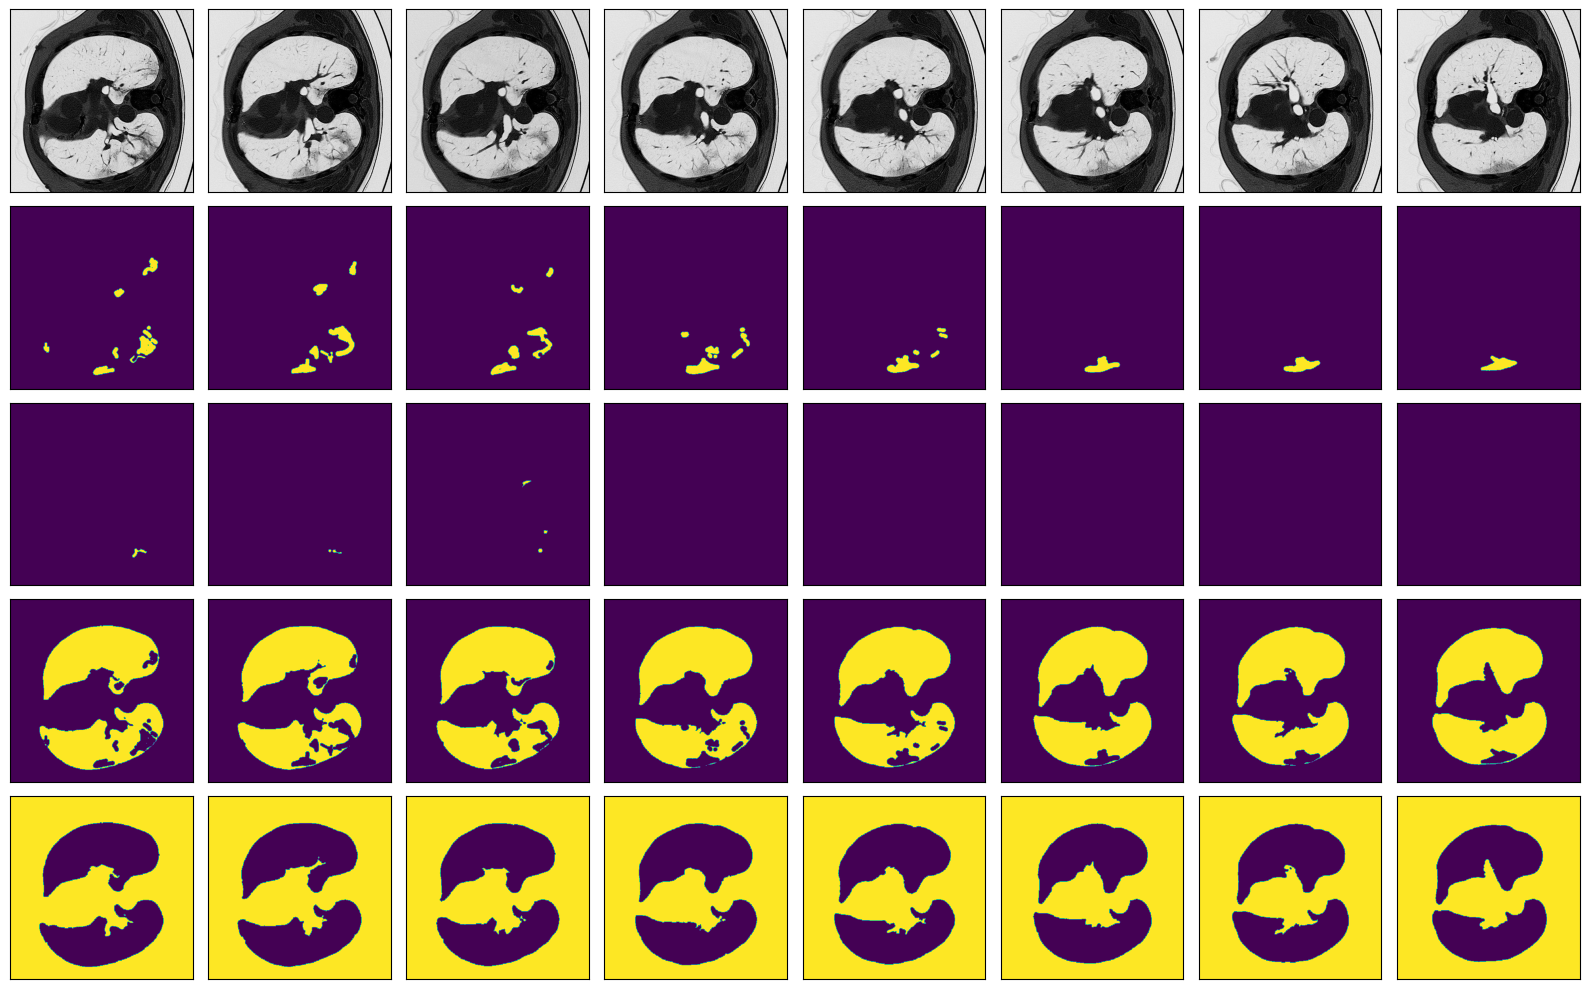

In [8]:
visualize(images_radiopedia[30:], masks_radiopedia[30:])

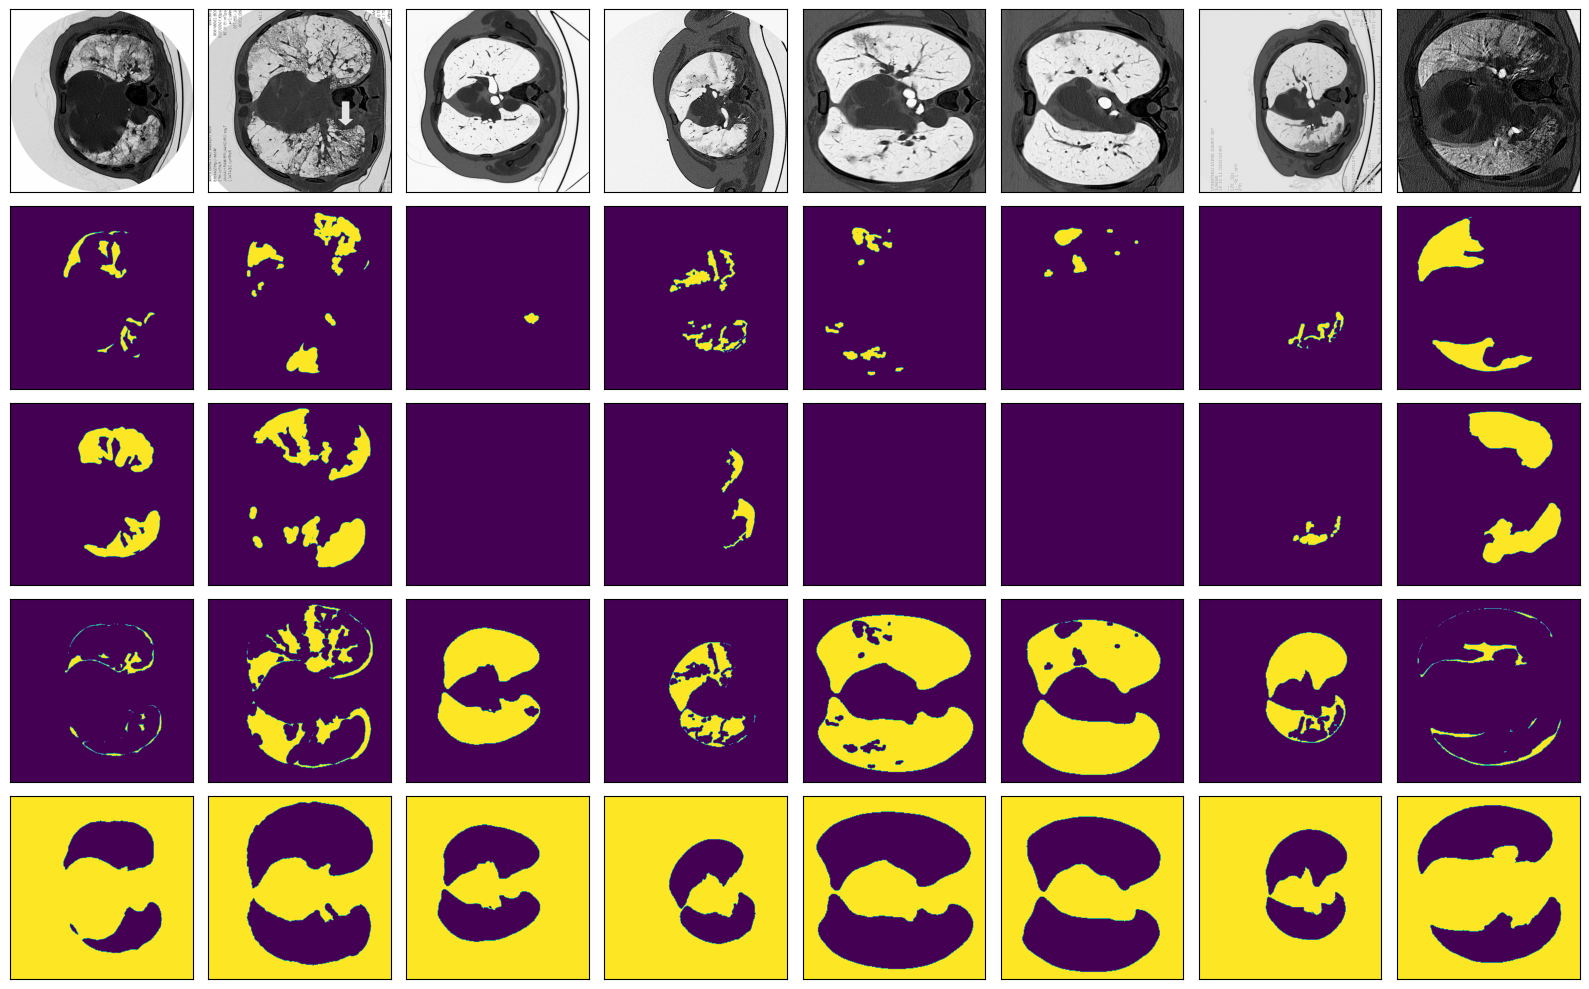

In [9]:
visualize(images_medseg, masks_medseg)

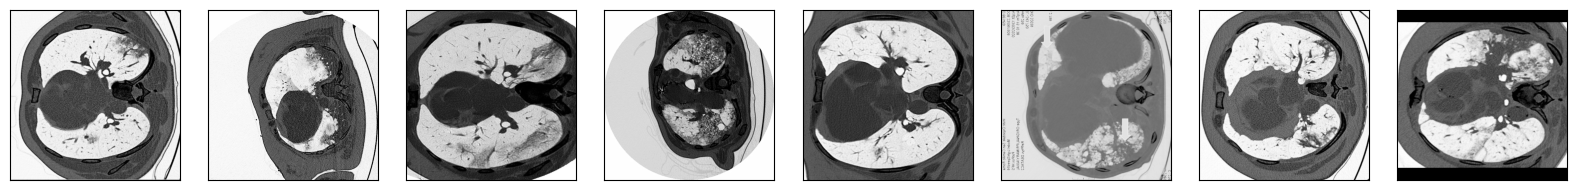

In [10]:
visualize(test_images_medseg)

In [11]:
def plot_hists(images1, images2=None):
    plt.hist(images1.ravel(), bins=100, density=True, color='b', alpha=1 if images2 is None else 0.5)
    if images2 is not None:
        plt.hist(images2.ravel(), bins=100, density=True, alpha=0.5, color='orange')
    plt.show();

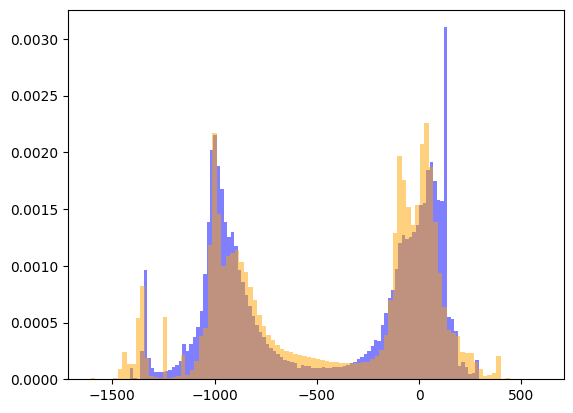

In [12]:
plot_hists(images_radiopedia, images_medseg)

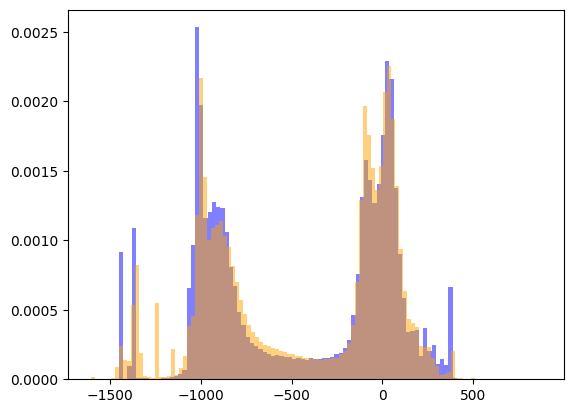

In [13]:
plot_hists(test_images_medseg, images_medseg)

In [14]:
def preprocess_images(images_arr, mean_std=None):
    images_arr[images_arr > 500] = 500
    images_arr[images_arr < -1500] = -1500
    min_perc, max_perc = np.percentile(images_arr, 5), np.percentile(images_arr, 95)
    images_arr_valid = images_arr[(images_arr > min_perc) & (images_arr < max_perc)]
    mean, std = (images_arr_valid.mean(), images_arr_valid.std()) if mean_std is None else mean_std
    images_arr = (images_arr - mean) / std
    print(f'mean {mean}, std {std}')
    return images_arr, (mean, std)

images_radiopedia, mean_std = preprocess_images(images_radiopedia)
images_medseg, _ = preprocess_images(images_medseg, mean_std)
test_images_medseg, _ = preprocess_images(test_images_medseg, mean_std)

mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281


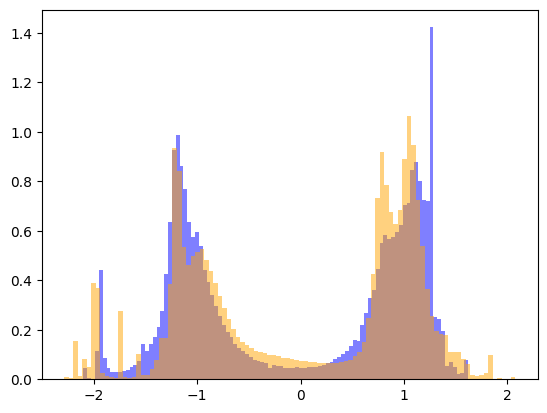

In [15]:
plot_hists(images_radiopedia, images_medseg)

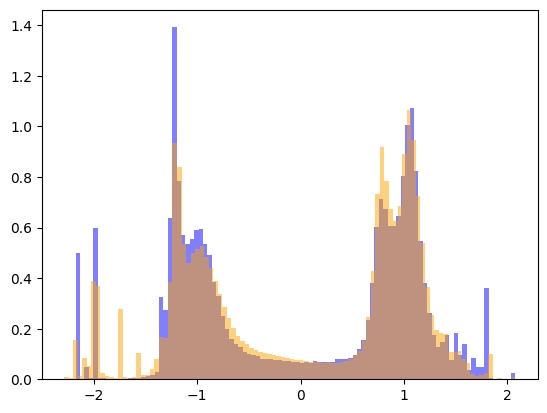

In [16]:
plot_hists(test_images_medseg, images_medseg)

In [17]:
val_indexes, train_indexes = list(range(24)), list(range(24, 100))

train_images = np.concatenate((images_medseg[train_indexes], images_radiopedia))
train_masks = np.concatenate((masks_medseg[train_indexes], masks_radiopedia))
val_images = images_medseg[val_indexes]
val_masks = masks_medseg[val_indexes]

batch_size = len(val_masks)


In [18]:
SOURCE_SIZE = 512
TARGET_SIZE = 224

train_augs = albumentations.Compose([
    albumentations.Rotate(limit=360, p=0.9, border_mode = cv2.BORDER_REPLICATE),
    albumentations.RandomSizedCrop((int(SOURCE_SIZE * 0.75), SOURCE_SIZE), 
                                   TARGET_SIZE, 
                                   TARGET_SIZE, 
                                   interpolation = cv2.INTER_NEAREST),
    albumentations.HorizontalFlip(p=0.5),

])

val_augs = albumentations.Compose([
    albumentations.Resize(TARGET_SIZE, TARGET_SIZE, interpolation = cv2.INTER_NEAREST)
])

In [19]:
class Dataset:   
    def __init__(
            self, 
            images, 
            masks,
            augmentations=None
    ):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations
    
    def __getitem__(self, i):
        image = self.images[i]
        mask = self.masks[i]
        
        if self.augmentations:
            sample = self.augmentations(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
        
    def __len__(self):
        return len(self.images)
    
    
class Dataloder(tensorflow.keras.utils.Sequence):
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        images = []
        masks = []
        for j in range(start, stop):
            image, mask = self.dataset[self.indexes[j]]
            images.append(image)
            masks.append(mask)
        
        images = np.stack(images, axis=0)
        masks = np.stack(masks, axis=0).astype(np.float32)
        
        return (images, masks)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)
            
train_dataset = Dataset(train_images, train_masks, train_augs)
val_dataset = Dataset(val_images, val_masks, val_augs)

train_dataloader = Dataloder(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = Dataloder(val_dataset, batch_size = batch_size, shuffle = False)

In [20]:
len(train_dataset)

905

In [21]:
assert train_dataloader[0][0].shape == (batch_size, TARGET_SIZE, TARGET_SIZE, 1)
assert train_dataloader[0][1].shape == (batch_size, TARGET_SIZE, TARGET_SIZE, 4)

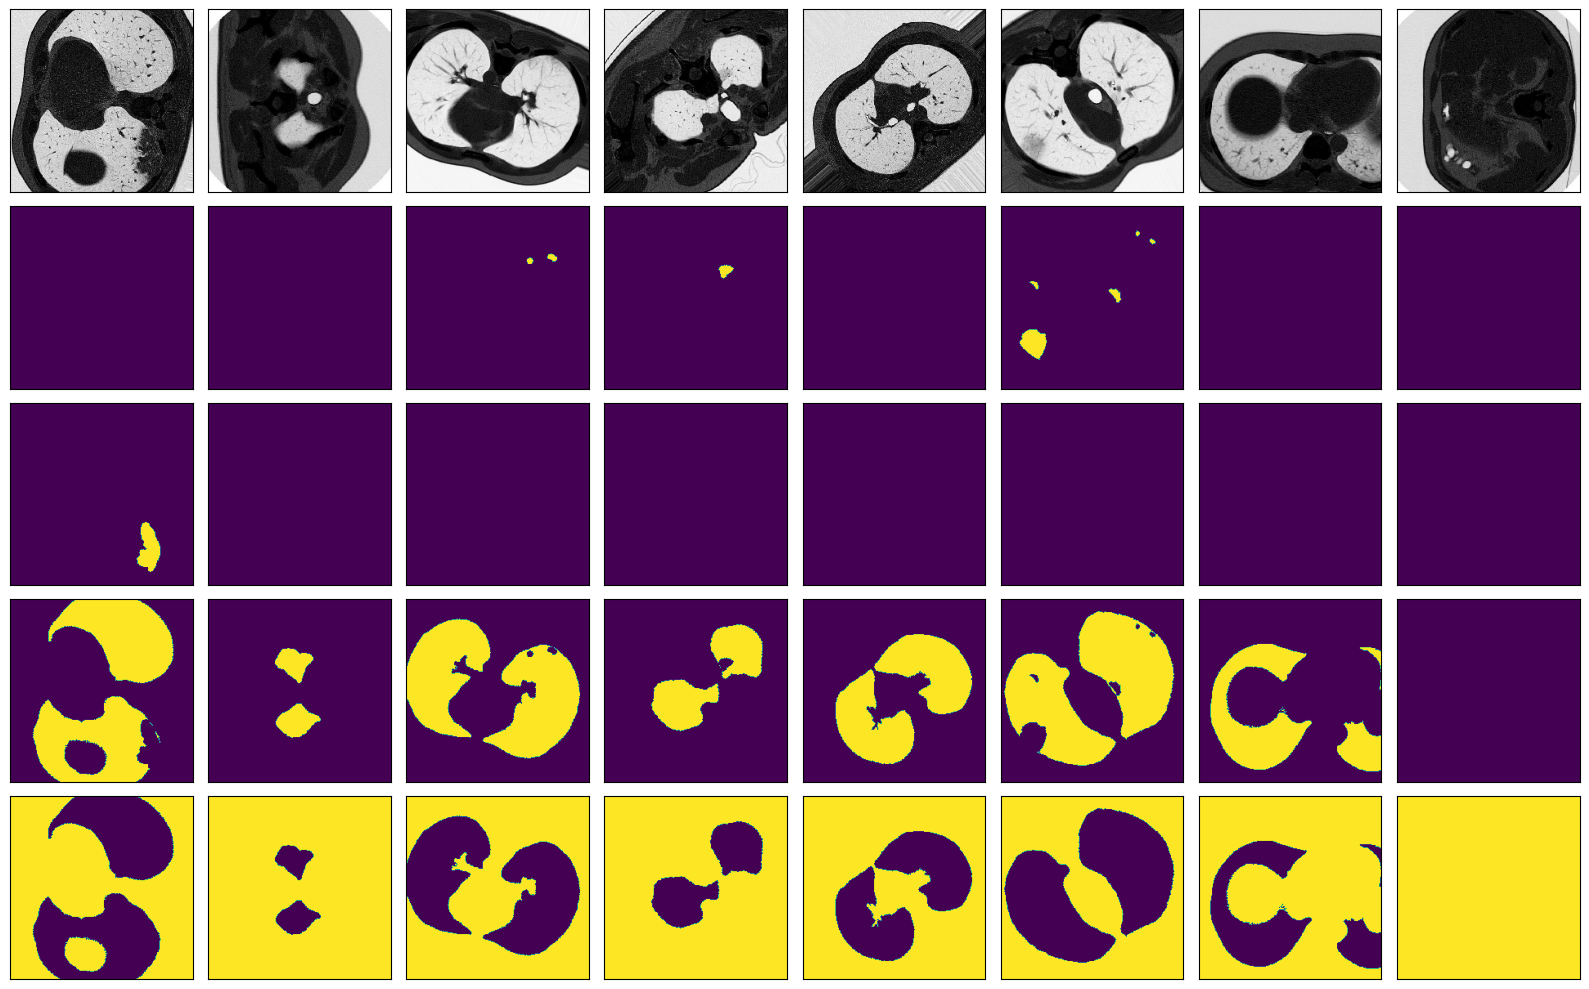

In [22]:
visualize(*next(iter(train_dataloader)))

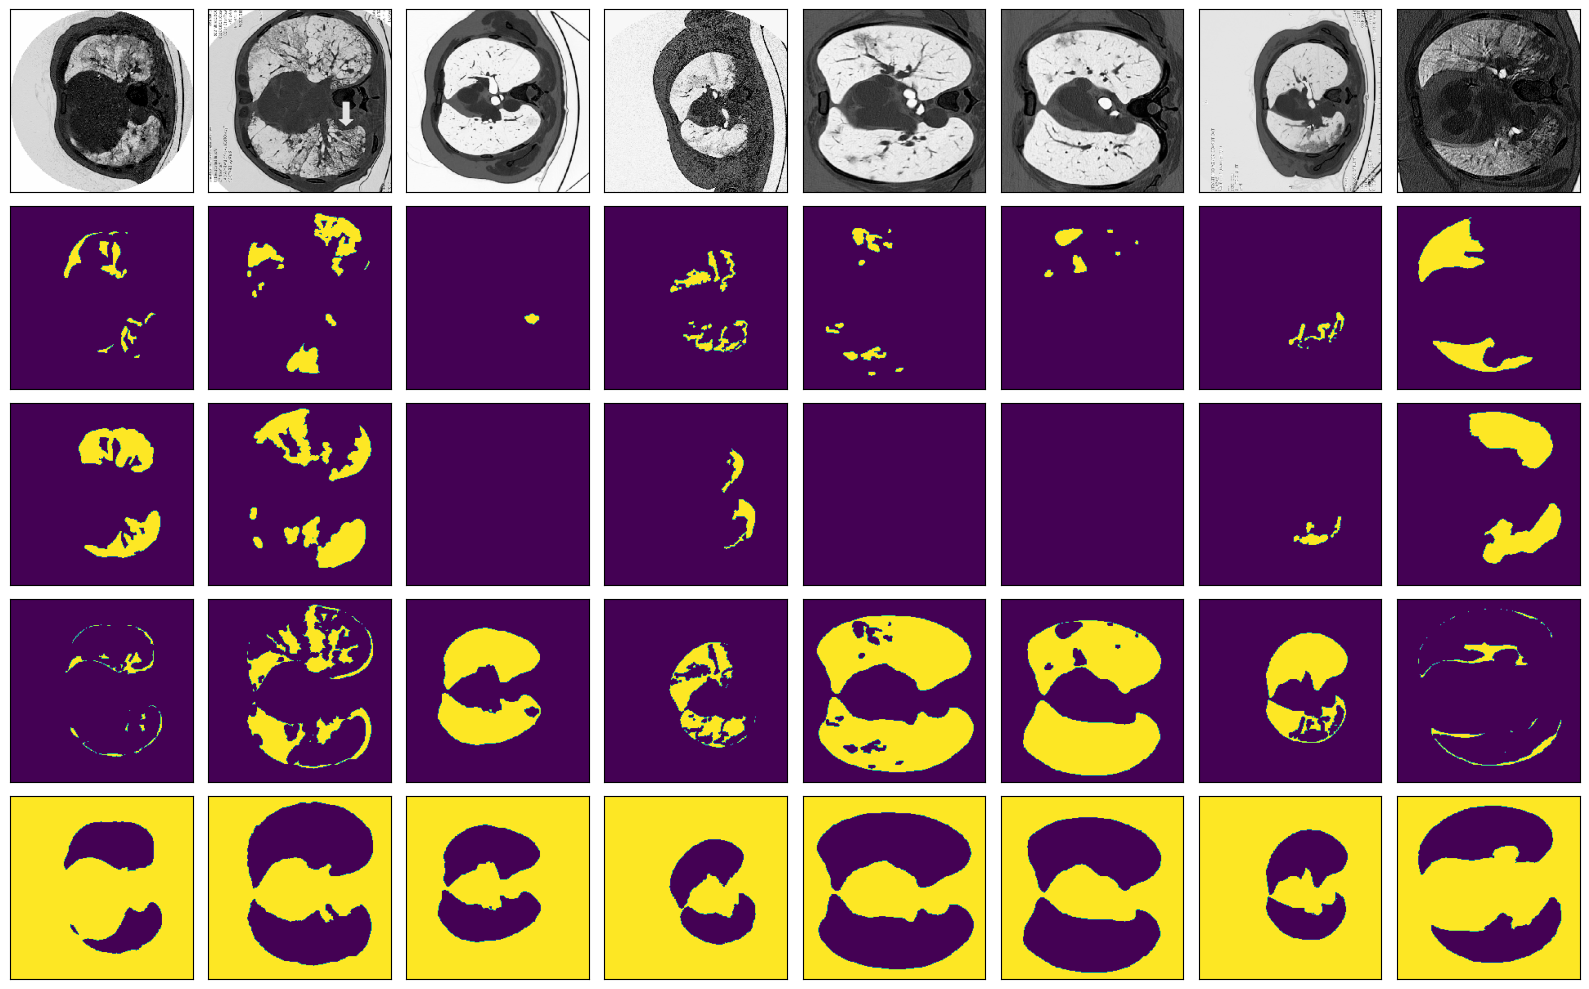

In [23]:
visualize(*next(iter(val_dataloader)))

# Model

In [24]:
#from keras.layers.advanced_activations import ELU
from keras.layers import ELU, PReLU, LeakyReLU

In [25]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Concatenate, UpSampling2D, Input, BatchNormalization, Activation
from keras.layers import ELU, PReLU, LeakyReLU

In [26]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


# ELUnet-EfficientNetB0 Encoder

In [63]:
def elunet_efficientnet(input_shape):
    encoder = tf.keras.applications.EfficientNetB0(input_shape=(input_shape[0], input_shape[1], 3), include_top=False, weights='imagenet')
    encoder.trainable = False

    encoder_outputs = [
        encoder.get_layer('block2a_expand_activation').output,  # 128x128
        encoder.get_layer('block3a_expand_activation').output,  # 64x64
        encoder.get_layer('block4a_expand_activation').output,  # 32x32
        encoder.get_layer('block6a_expand_activation').output,  # 16x16
        encoder.get_layer('top_activation').output  # 8x8
    ]
 
    # Downsampling path (contracting path)
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(3, (1, 1), activation='elu')(inputs)
    skips = []
    for down in encoder_outputs:
        x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='elu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='elu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        skips.append(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
 
    # Bottleneck
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='elu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='elu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
 
    # Upsampling path (expanding path)
    for up, skip in zip(reversed(encoder_outputs), reversed(skips)):
        x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='elu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='elu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
 
    # Output
    outputs = tf.keras.layers.Conv2D(filters=4, kernel_size=1, activation='softmax')(x)
 
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [40]:
input_shape = (TARGET_SIZE, TARGET_SIZE, 1)  # Adjust the number of channels according to the data
with strategy.scope():
    model = elunet_efficientnet(input_shape)
    model.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
              
                metrics = (['accuracy', tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.MeanIoU(num_classes=4),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='AUC'),
                        f1_score, specificity, sensitivity, iou, dice_coefficient,tversky]))

print(model.input_shape)
print(model.output_shape)
model.summary()

(None, 224, 224, 1)
(None, 224, 224, 4)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_96 (Conv2D)             (None, 224, 224, 3)  6           ['input_10[0][0]']               
                                                                                                  
 conv2d_97 (Conv2D)             (None, 224, 224, 32  896         ['conv2d_96[0][0]']              
                                )                                                                 
                                                    

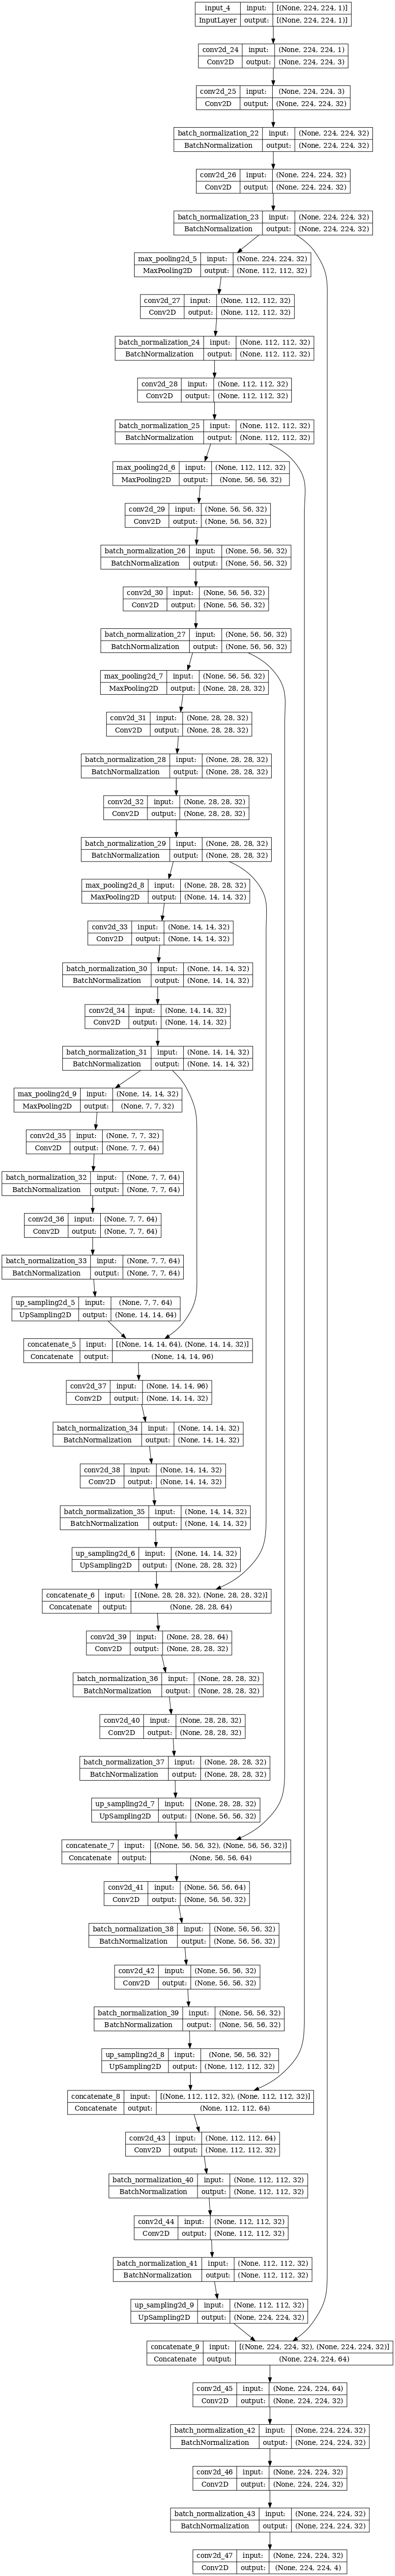

In [33]:
tf.keras.utils.plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

# Train

In [41]:
%%time
history = model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader) * 6,
    epochs = 10,
    validation_data = val_dataloader,
    validation_steps = len(val_dataloader),
    callbacks=callbacks,
    workers = 4)

Epoch 1/10
222/222 [==============================] - 81s 218ms/step - loss: 0.1901 - accuracy: 0.9539 - precision: 0.9647 - mean_io_u: 0.3750 - recall: 0.9439 - AUC: 0.9919 - f1_score: 0.9520 - specificity: 0.9885 - sensitivity: 0.9439 - iou: 0.8213 - dice_coefficient: 0.8950 - tversky: 0.8949 - val_loss: 4.7524 - val_accuracy: 0.3007 - val_precision: 0.3035 - val_mean_io_u: 0.3750 - val_recall: 0.2730 - val_AUC: 0.5341 - val_f1_score: 0.2874 - val_specificity: 0.7912 - val_sensitivity: 0.2730 - val_iou: 0.1813 - val_dice_coefficient: 0.3068 - val_tversky: 0.3068 - lr: 0.0010
Epoch 2/10
222/222 [==============================] - 50s 225ms/step - loss: 0.0858 - accuracy: 0.9750 - precision: 0.9775 - mean_io_u: 0.3750 - recall: 0.9731 - AUC: 0.9978 - f1_score: 0.9753 - specificity: 0.9925 - sensitivity: 0.9731 - iou: 0.9143 - dice_coefficient: 0.9551 - tversky: 0.9550 - val_loss: 0.4891 - val_accuracy: 0.8304 - val_precision: 0.8466 - val_mean_io_u: 0.3750 - val_recall: 0.8103 - val_AUC

In [44]:
model.save("Model-EFF.h5")
print('Model save to Disk')

Model save to Disk


# Results

In [45]:
import pandas as pd
df = pd.DataFrame(history.history) 
df.to_excel("outputEFF.xlsx")
#df.to_csv("output1.csv")
df.head(10)

loss  accuracy  precision  mean_io_u    recall       AUC  f1_score  \
0  0.190147  0.953890   0.964700   0.374986  0.943936  0.991880  0.951966   
1  0.085791  0.975033   0.977542   0.374986  0.973120  0.997817  0.975319   
2  0.071387  0.976786   0.979258   0.374986  0.974903  0.998587  0.977068   
3  0.060145  0.979808   0.982063   0.374986  0.978089  0.998969  0.980066   
4  0.049425  0.982584   0.984533   0.374986  0.981089  0.999300  0.982803   
5  0.046665  0.983282   0.985112   0.374986  0.981869  0.999382  0.983484   
6  0.043478  0.984289   0.986048   0.374986  0.982896  0.999430  0.984465   
7  0.042185  0.984688   0.986370   0.374986  0.983360  0.999452  0.984858   
8  0.039387  0.985571   0.987145   0.374986  0.984329  0.999522  0.985731   
9  0.044214  0.984266   0.985831   0.374986  0.983014  0.999342  0.984416   

   specificity  sensitivity       iou  ...  val_mean_io_u  val_recall  \
0     0.988485     0.943936  0.821267  ...       0.375000    0.273011   
1     0.992547     0.973120  0.914336  ...       0.375000    0.810331   
2     0.993116     0.974903  0.928618  ...       0.375000    0.787599   
3     0.994044     0.978089  0.938447  ...       0.375000    0.930571   
4     0.994862     0.981090  0.948648  ...       0.375000    0.932998   
5     0.995053     0.981869  0.951247  ...       0.375000    0.928016   
6     0.995364     0.982896  0.954718  ...       0.375000    0.939898   
7     0.995470     0.983360  0.956132  ...       0.375000    0.936863   
8     0.995727     0.984330  0.958758  ...       0.375000    0.936720   
9     0.995290     0.983014  0.955468  ...       0.392065    0.868729   

    val_AUC  val_f1_score  val_specificity  val_sensitivity   val_iou  \
0  0.534148      0.287365         0.791169         0.273011  0.181270   
1  0.958354      0.828112         0.951074         0.810331  0.600383   
2  0.953854      0.799119         0.938804         0.787599  0.631987   
3  0.986142      0.933766         0.979154         0.930571  0.856137   
4  0.990230      0.937241         0.980698         0.932998  0.857954   
5  0.989922      0.931853         0.978758         0.928016  0.844235   
6  0.991000      0.943369         0.982426         0.939898  0.872294   
7  0.991866      0.941004         0.981894         0.936863  0.859407   
8  0.991566      0.940730         0.981750         0.936720  0.851902   
9  0.941710      0.871599         0.958448         0.868729  0.759165   

   val_dice_coefficient  val_tversky     lr  
0              0.306761     0.306762  0.001  
1              0.750181     0.750182  0.001  
2              0.774440     0.774440  0.001  
3              0.922303     0.922303  0.001  
4              0.923329     0.923329  0.001  
5              0.915365     0.915365  0.001  
6              0.931657     0.931657  0.001  
7              0.924246     0.924246  0.001  
8              0.919982     0.919982  0.001  
9              0.862789     0.862789  0.001  

[10 rows x 25 columns]

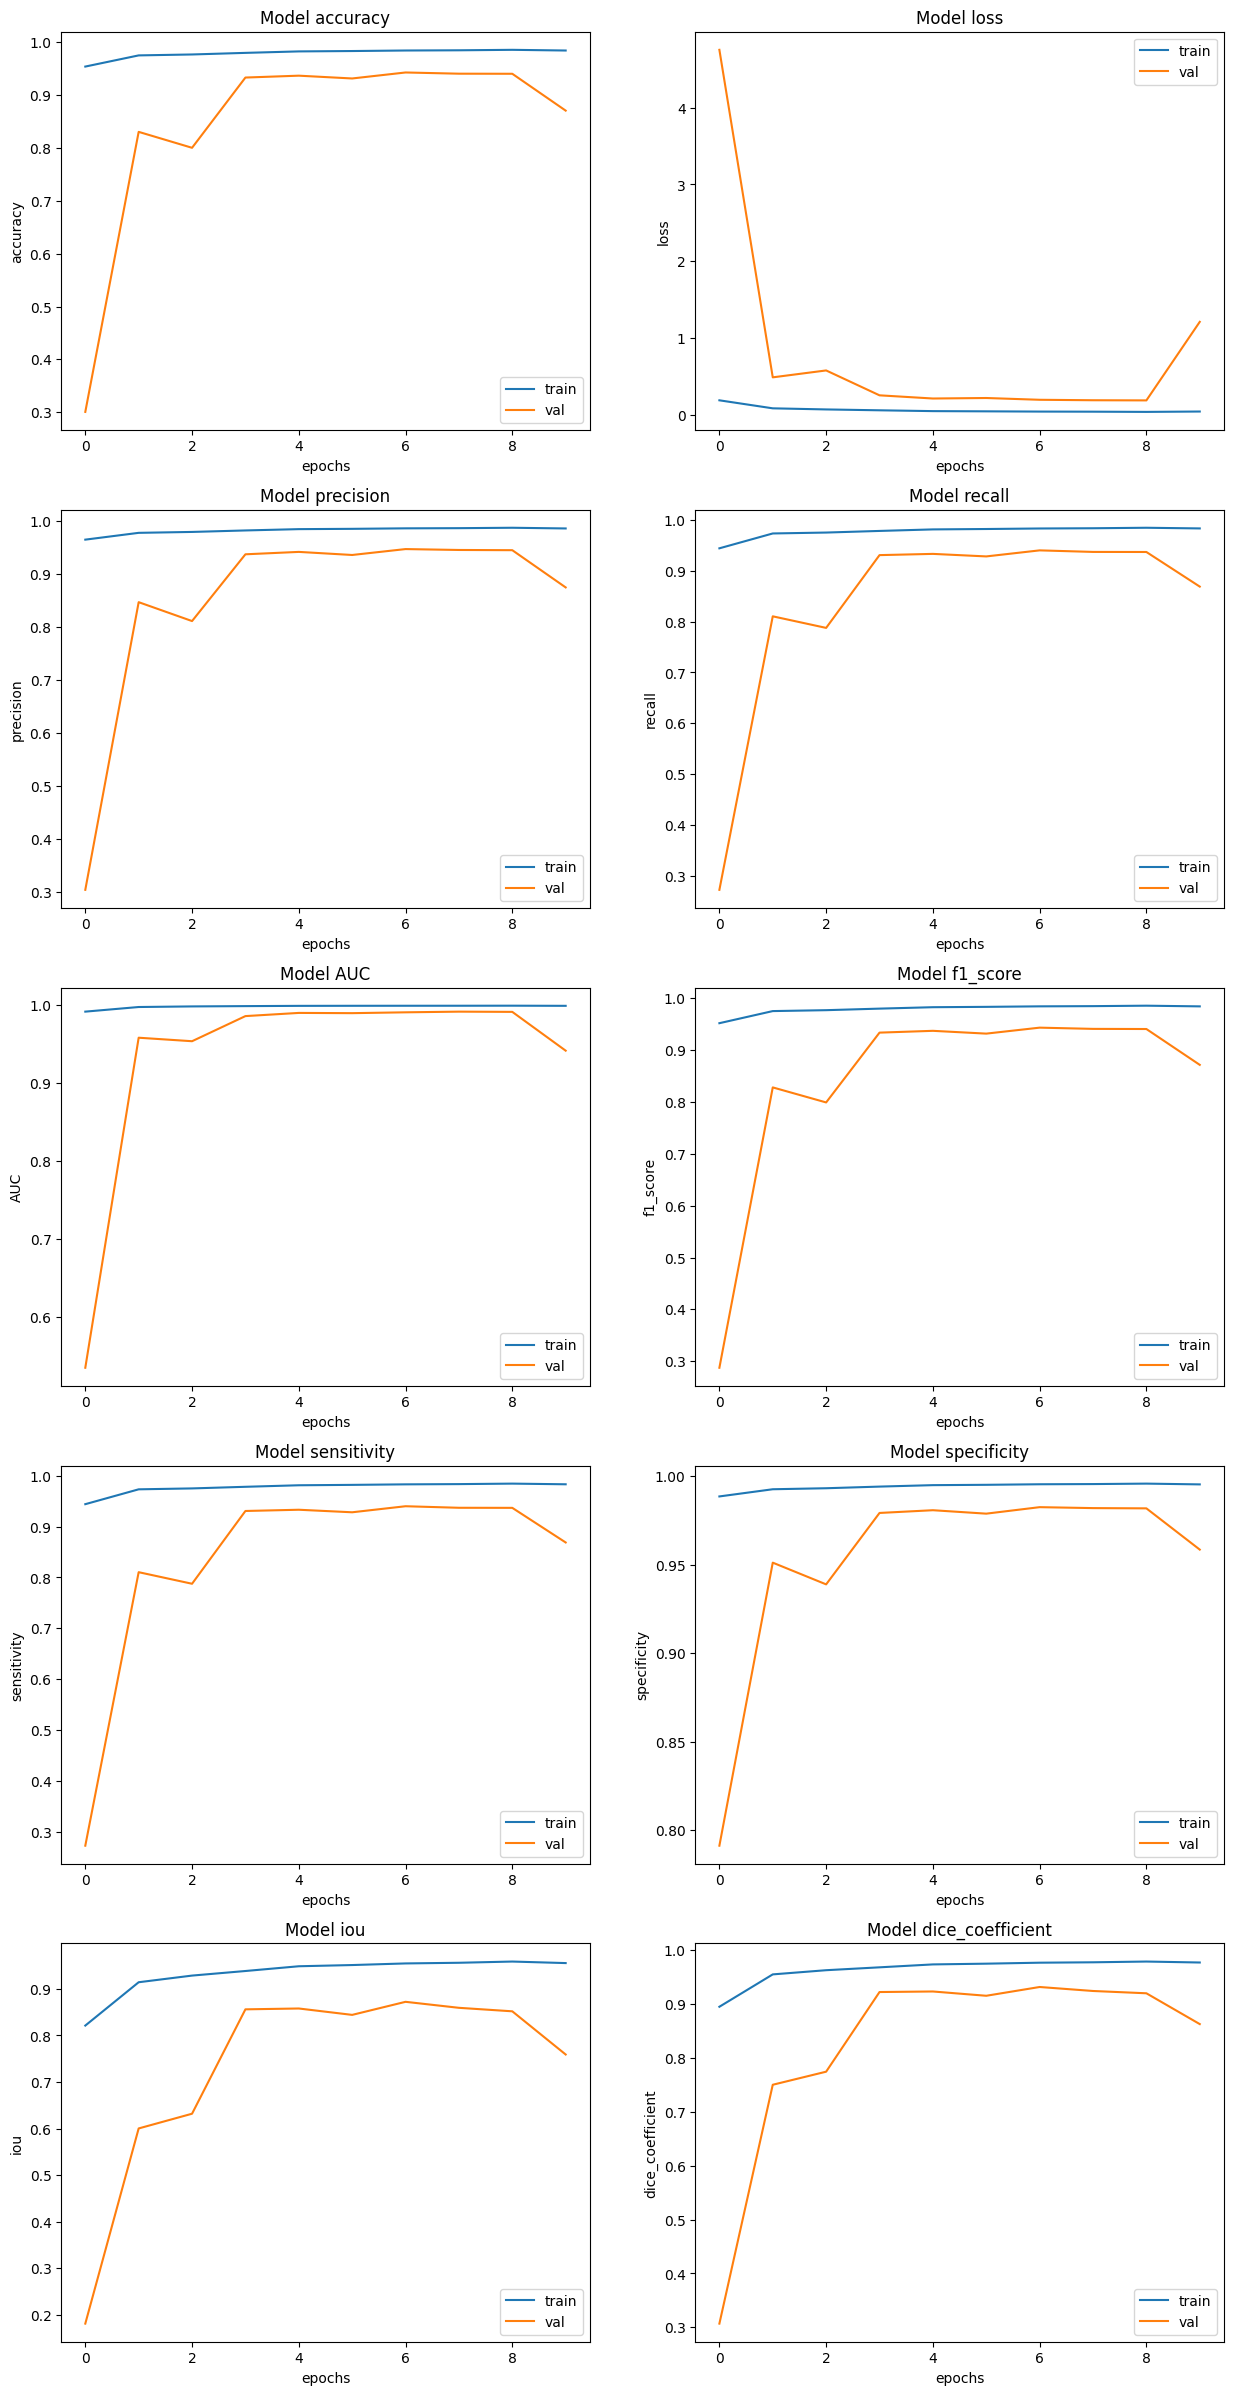

In [46]:
# Interpreting the Metrics
fig, ax = plt.subplots(5, 2, figsize=(15, 30))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss', 'precision', 'recall', 'AUC', 'f1_score','sensitivity', 'specificity','iou', 'dice_coefficient']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model-Results-EFF.png")

# Test model and inference Time

In [47]:
%%time
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(val_dataloader, batch_size=16, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data
1/1 [==============================] - 0s 469ms/step - loss: 1.2116 - accuracy: 0.8706 - precision: 0.8745 - mean_io_u: 0.3921 - recall: 0.8687 - AUC: 0.9417 - f1_score: 0.8716 - specificity: 0.9584 - sensitivity: 0.8687 - iou: 0.7592 - dice_coefficient: 0.8628 - tversky: 0.8628
test loss, test acc: [1.2115858793258667, 0.8705780506134033, 0.8745145201683044, 0.39206528663635254, 0.8687288761138916, 0.9417102336883545, 0.8715986609458923, 0.9584481716156006, 0.8687288761138916, 0.759164571762085, 0.8627888560295105, 0.8627889752388]
CPU times: user 476 ms, sys: 100 ms, total: 576 ms
Wall time: 571 ms


In [50]:
%%time
model0 = tf.keras.models.load_model('Model-EFF.h5',
                                           compile=False,
                                           custom_objects={
                                                'Accuracy': 'accuracy', 
                                                'Precision': tf.keras.metrics.Precision(), 
                                                'Recall': tf.keras.metrics.Recall(),
                                                'F1_Score': f1_score,
                                                'Dice': dice_coefficient})

model0.compile(Adam(learning_rate=0.001, amsgrad=True),
              loss = "categorical_crossentropy")

CPU times: user 590 ms, sys: 11.9 ms, total: 601 ms
Wall time: 588 ms


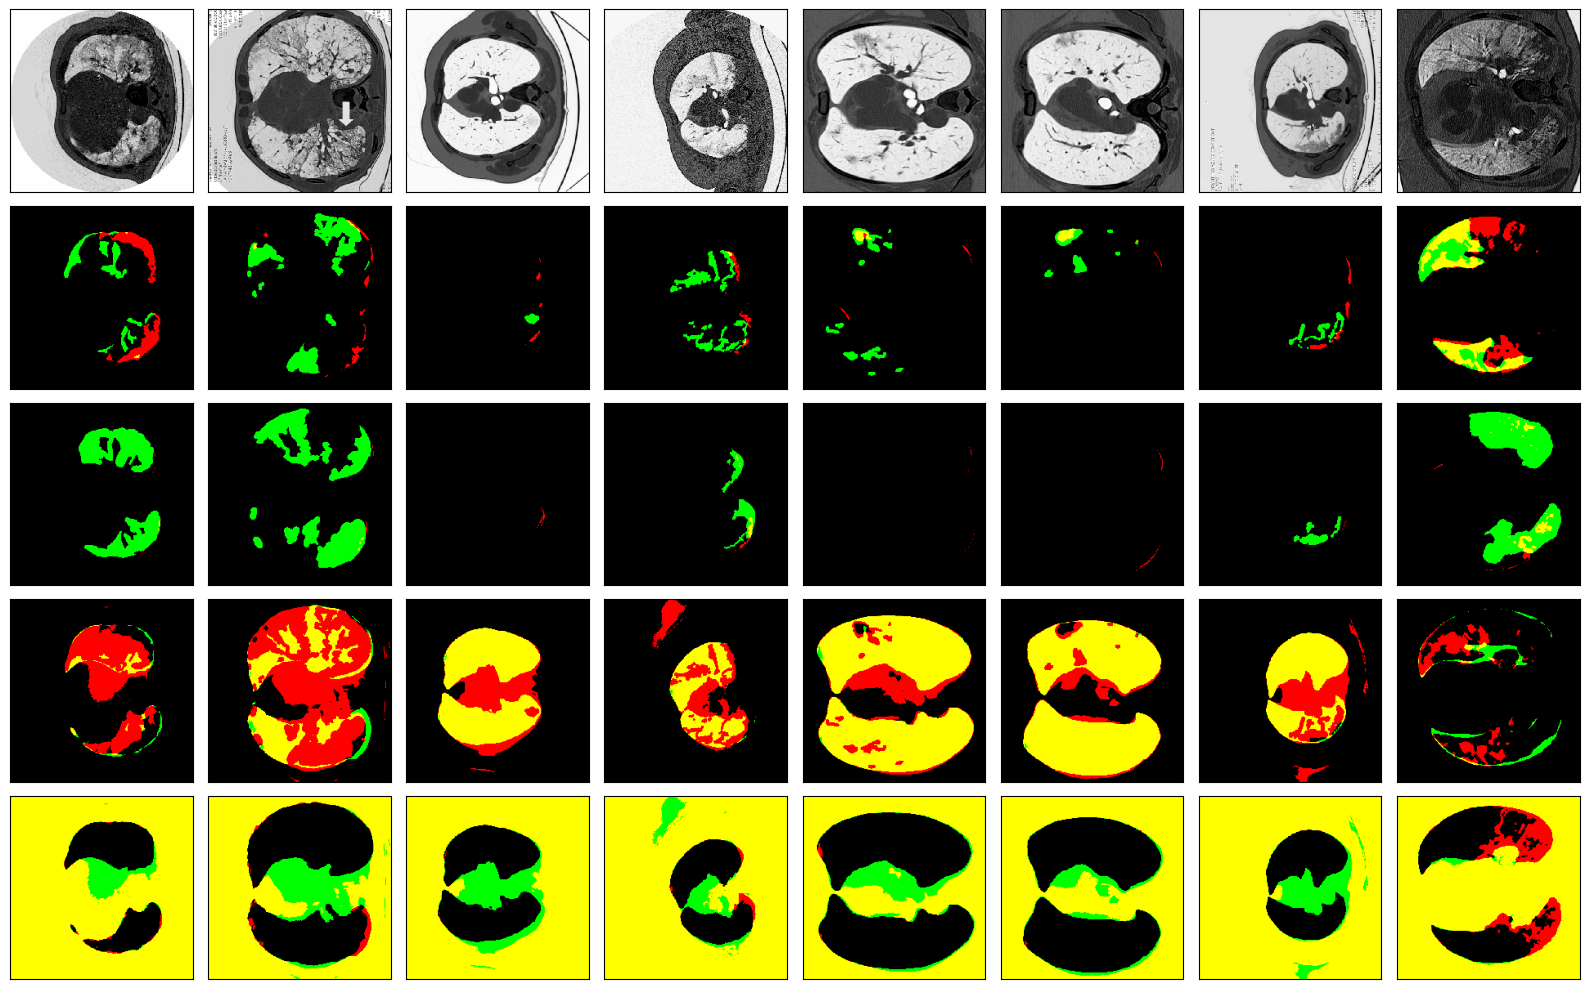

CPU times: user 4.59 s, sys: 196 ms, total: 4.79 s
Wall time: 4.6 s


In [49]:
%%time
input = val_dataloader[0]
image_batch, mask_batch = input

preds = model.predict_on_batch(image_batch)
visualize(image_batch, mask_batch, pred_batch=preds)

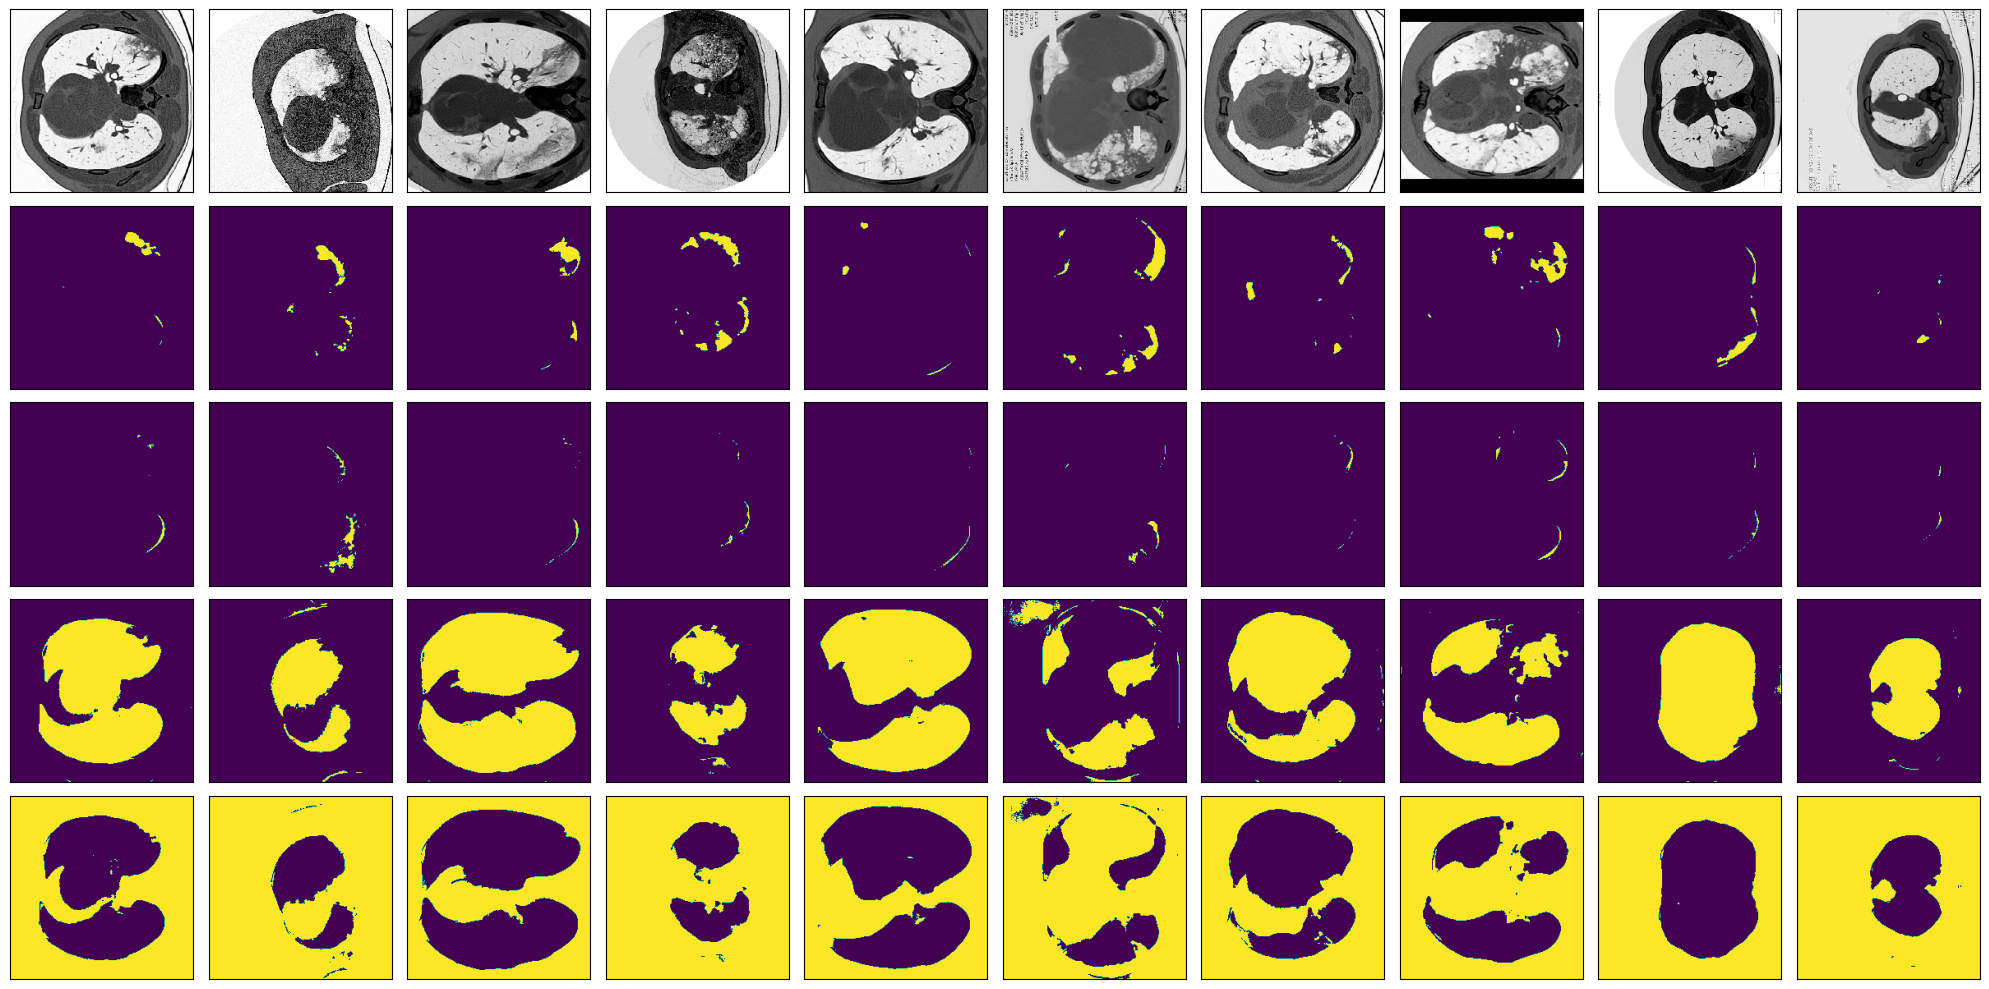

CPU times: user 2.55 s, sys: 177 ms, total: 2.73 s
Wall time: 2.47 s


In [91]:
%%time
image_batch = np.stack([val_augs(image=img)['image'] for img in test_images_medseg], axis=0)
test_preds = model.predict_on_batch(image_batch)
test_masks_prediction = test_preds > 0.3
visualize(image_batch, test_masks_prediction, num_samples=len(test_images_medseg))

# Quantization

In [52]:
keras_file = "Model-EFF.h5"
tf.keras.models.save_model(model, keras_file)

In [53]:
# WHOLE MODEL
tflite_model = tf.keras.models.load_model(keras_file)
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
tflite_save = converter.convert()
open("EFF.tflite", "wb").write(tflite_save)

1188528